# Wstęp
Zadanie 11 jest drugą częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem drugiego etapu prac jest przygotowanie modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. Dopuszczalne jest rozwiązanie, które działa podobnie jak klasyfikator z poprzedniego zadania, przy czym w tym wypadku skonstruowany zostanie regresor, a zmienną predykowaną będzie np. średni kurs w następnym dniu pod warunkiem obserwacji z dni poprzednich.

# Warunki zaliczenia

Do zaliczenia drugiego etapu należy wykonać następujące kroki:

1.   Klasyfikacja zbioru tweetów przy pomocy 2 modeli EmoTweet opracowanych w etapie nr 1 (gdyby sieci LSTM były zbyt wolne, można użyć modeli opartych o fastText).
2.   Przygotowanie modelu LSTM, dla którego każdy element sekwencji będzie multimodalny, tj. będzie opisany cechami pochodzącymi z różnych źródeł:
   * Dane z giełdy kryptowalutowej
   * Zagregowane wartości emocji z tweetów

# Zbiór tweetów

Zbiór tweetów pochodzi z serwisu [Twitter](https://twitter.com/) i jest podzbiorem 2 milionów wiadomości dotyczących [Bitcoina](https://en.wikipedia.org/wiki/Bitcoin) z okresu od stycznia 2018 do maja 2020 roku.
## Pobranie

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Counting objects: 100% (1057/1057), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 3998 (delta 922), reused 889 (delta 855), pack-reused 2941
Receiving objects: 100% (3998/3998), 8.30 MiB | 22.60 MiB/s, done.
Resolving deltas: 100% (2529/2529), done.


In [ ]:
!cd fastText && mkdir build && cd build && cmake ..  && make && make install

CMake Deprecation Warning at CMakeLists.txt:9 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (1.1s)
-- Generating done (0.0s)
-- Build files have been written to: /content/fastText/build
[  2%] Building CXX object CMakeFiles/fasttext-shared.dir/src/args.cc.o
[ 

In [ ]:
!cd fastText && pip install .

Processing /content/fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4239624 sha256=b1465a35a55e7c4694a6914b45d74c74c53308b0494e2a42fea323b699dcc2dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-163inlk2/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext


In [ ]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 746.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.3 MB/s eta 0:00:00


In [ ]:
import fasttext
import numpy as np
import torch
from torch import nn
from google.colab import drive
import py7zr
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')
!git clone https://github.com/cardiffnlp/tweeteval '/content/drive/My Drive/tweeteval'
data_dir = '/content/drive/My Drive/tweeteval'

Mounted at /content/drive
fatal: destination path '/content/drive/My Drive/tweeteval' already exists and is not an empty directory.


In [ ]:


MODEL_PATH = 'drive/My Drive/tweeteval/fasttext_tweetmodel_btc_sg_20_en.bin'
model = fasttext.load_model(MODEL_PATH)

def text_to_vector_sequence(text):
    tokens = fasttext.tokenize(text)
    token_vectors = [model.get_word_vector(token) for token in tokens]
    token_vectors_np = np.array(token_vectors)
    return torch.tensor(token_vectors_np, dtype=torch.float32)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)


In [ ]:
embedding_dim = 20
hidden_dim = 128
output_dim = 1
model_irony = LSTMModel(embedding_dim, hidden_dim, output_dim)
model_off = LSTMModel(embedding_dim, hidden_dim, output_dim)
model_irony.load_state_dict(torch.load(data_dir + '/model_lstm_irony.pth'))
model_irony.eval()
model_off.load_state_dict(torch.load(data_dir + '/model_lstm_off.pth'))
model_off.eval()

LSTMModel(
  (lstm): LSTM(20, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# należy wgrać plik z katalogu "dane" o nazwie bitcoin_tweets_2M.csv.7z

## Rozpakowanie

In [ ]:

archive_path = '/content/drive/My Drive/tweeteval/'
extract_path = '/content/drive/My Drive/tweeteval/lab11_data/'
if len(os.listdir(extract_path)) == 0 :
  os.makedirs(extract_path, exist_ok=True)
  with py7zr.SevenZipFile(archive_path + 'bitcoin_tweets_2M.csv.7z', mode='r') as z:
      z.extractall(path=extract_path )

## Zawartość
Dane zawierają następujące kolumny:
* `timestamp` - data wysłania wiadomości
* `likes` - liczba polubień wiadomości
* `retweets` - liczba przekazań dalej wiadomości
* `username` - nick użytkownika
* `text` - tekst tweeta "zanonimizowany" przy pomocy metody [`preprocess`](https://github.com/cardiffnlp/tweeteval/blob/main/TweetEval_Tutorial.ipynb), która była użyta przy tworzeniu zbioru [TweetEval](https://github.com/cardiffnlp/tweeteval)

In [ ]:
tweets_data = pd.read_csv(extract_path + 'bitcoin_tweets_2M.csv')
tweets_data

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


# Dane z giełdy [Bitstamp](https://www.bitstamp.net/)
Zbiór pochodzi z serwisu Bitstamp i zawiera informacje o kursie Bitcoina od stycznia 2017 roku do kwietnia 2021 roku, zarówno w interwałach jednodniowych (24h), jak też godzinowych (1h).

## Pobranie


In [ ]:
# należy wgrać plik z katalogu "dane" o nazwie bitstamp.7z

## Rozpakowanie

In [ ]:
if len(os.listdir(extract_path)) == 1 :
  os.makedirs(extract_path, exist_ok=True)
  with py7zr.SevenZipFile(archive_path + 'bitstamp.7z', mode='r') as z:
      z.extractall(path=extract_path )

## Zawartość
Kwoty są podane w dolarach amerykańskich (kurs BTC/USD). Daty wyznaczają moment zamknięcia, a momentem otwarcia jest godzina wstecz (wariant 1h) lub dzień wstecz (wariant 24h). Każdy ze zbiorów zawiera następujące kolumny:
* `timestamp` - data w [formacie Unix](https://www.epochconverter.com/)
* `date` - j.w. w formacie YYYY-MM-DD HH:MM:SS
* `open` - kurs otwarcia
* `high` - najwyższa wartość
* `low` - najniższa wartość
* `close` - kurs zamknięcia
* `volume` - wolumen obrotu BTC

Interwał godzinowy:



In [ ]:
bitstamp_data_1h = pd.read_csv(extract_path + 'Bitstamp_BTCUSD_1h_2017_2018_2019_2020_2021-04-08.csv')
bitstamp_data_1h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,966.99,964.60,966.60,102.484806
1,1483232400,2017-01-01 01:00:00,966.60,966.60,962.54,963.87,149.025554
2,1483236000,2017-01-01 02:00:00,964.35,965.75,961.99,963.97,94.267396
3,1483239600,2017-01-01 03:00:00,963.88,964.71,960.53,962.83,77.619667
4,1483243200,2017-01-01 04:00:00,960.61,963.64,960.60,963.46,46.810220
...,...,...,...,...,...,...,...
37387,1617822000,2021-04-07 19:00:00,55832.62,56127.66,55441.93,56127.66,289.995730
37388,1617825600,2021-04-07 20:00:00,56075.95,56242.37,55690.00,56204.82,175.990086
37389,1617829200,2021-04-07 21:00:00,56243.09,56401.40,56053.20,56199.64,281.857236
37390,1617832800,2021-04-07 22:00:00,56160.72,56549.00,56111.13,56449.54,117.778871


Interwał dzienny:

In [ ]:
bitstamp_data_24h = pd.read_csv(extract_path + 'Bitstamp_BTCUSD_24h_2017_2018_2019_2020_2021-04-08.csv')
bitstamp_data_24h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,1005.00,960.53,997.75,6850.593309
1,1483315200,2017-01-02 00:00:00,997.75,1032.00,990.01,1012.54,8167.381030
2,1483401600,2017-01-03 00:00:00,1011.44,1039.00,999.99,1035.24,9089.658025
3,1483488000,2017-01-04 00:00:00,1035.51,1139.89,1028.56,1114.92,21562.456972
4,1483574400,2017-01-05 00:00:00,1114.38,1136.72,885.41,1004.74,36018.861120
...,...,...,...,...,...,...,...
1553,1617408000,2021-04-03 00:00:00,58967.61,59801.39,56922.00,57064.42,1663.268353
1554,1617494400,2021-04-04 00:00:00,57064.13,58501.00,56466.25,58212.18,1440.631820
1555,1617580800,2021-04-05 00:00:00,58213.69,59280.00,56800.00,59125.00,2402.437135
1556,1617667200,2021-04-06 00:00:00,59135.36,59473.90,57216.00,58018.30,2711.397847


# Realizacja zadania

Szczegółowa realizacja zadania powinna zawierać następujące etapy:

## Przygotowanie danych (5 pkt.)


1.   Wykorzystać modele utworzone w etapie 1 do opisania wymiarami afektywnymi (ZJAWISKO_1 oraz ZJAWISKO_2) zbioru tweetów `tweets_data`.
2.   Wyodrębnić podzbiór danych `bitstamp_data_*` z okresu dla którego są dostępne tweety.
3.   Dokonać agregacji informacji afektywnej dla interwału godzinowego oraz interwału dziennego. Przykładowo, jeżeli rozpatruję interwał dzienny, to dla kursu z daty zamknięcia 2017-01-02 00:00:00 agreguję informację afektywną z tweetów pojawiających się pomiędzy 2017-01-01 00:00:00 a 2017-01-02 00:00:00. Dodatkowo dokonać agregacji dodatkowych metadanych opisujących tweety, tj. `likes` oraz `retweets`. Metoda agregacji jest dowolna. Przykładowe możliwości:
 * suma
 * średnia
 * histogram
4.   Dokonać podziału danych na zbiór uczący (80%), walidacyjny (10%) oraz testowy (10%) poprzez wyznaczenie 2 punktów podziału na osi czasu (dane są ułożone chronologicznie). Innymi słowy, uczenie i strojenie modelu odbywa się na danych historycznych, a testowanie na aktualnych.


## Budowanie modeli (5 pkt.)

Model ma służyć do przewidywania kursu **w przyszłości** na podstawie danych **historycznych**. W każdym badaniu w sekcji **Ewaluacja modeli** należy sprawdzić jakość predykcji na 2 typach modeli:
1. **Model dzienny** - model, który w chwili T przewiduje (do wyboru jedna z opcji):
 * kurs zamknięcia w chwili T+1
 * średni kurs dla okresu od T do T+1 (wymaga obliczenia na podstawie danych godzinowych)
2. **Model godzinowy** - model, który w chwili T przewiduje kurs zamknięcia dla okresu T+1.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


Zad 1

In [ ]:
create_tweets = False
if create_tweets:
  tweets_data[['text']] = tweets_data[['text']].fillna("Bitcoin won't pass 60k xd")
  tweets_data['tensors'] = tweets_data['text'].apply(text_to_vector_sequence)
  tweets_data['irony']  = tweets_data['tensors'].apply(lambda x: torch.argmax(model_irony(x), dim = 1))
  tweets_data['offensive']  = tweets_data['tensors'].apply(lambda x: torch.argmax(model_off(x), dim = 1))
  tweets_data = tweets_data[['timestamp', 'likes', 'retweets', 'irony', 'offensive']]
  tweets_data.to_parquet(extract_path + 'tweets_df.parquet')
else:
  tweets_data = pd.read_parquet(extract_path + 'tweets_df.parquet')

Zad 2

In [ ]:
max_date = tweets_data['timestamp'].max()
min_date = tweets_data['timestamp'].min()

bitstamp_data_24h_cut = bitstamp_data_24h[(bitstamp_data_24h['date'] >= min_date) & (bitstamp_data_24h['date'] <= max_date)].reset_index(drop = True)
bitstamp_data_1h_cut = bitstamp_data_1h[(bitstamp_data_1h['date'] >= min_date) & (bitstamp_data_1h['date'] <= max_date)].reset_index(drop = True)

Zad 3

In [ ]:
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'])
tweets_data['hours'] = tweets_data['timestamp'].dt.floor('H')
tweets_data['days'] = tweets_data['timestamp'].dt.floor('D')

In [ ]:
tweets_data_1h = tweets_data[['likes', 'retweets', 'irony', 'offensive', 'hours']].groupby('hours').mean().reset_index()
tweets_data_24h = tweets_data[['likes', 'retweets', 'irony', 'offensive', 'days']].groupby('days').mean().reset_index()

In [ ]:
bitstamp_data_1h_cut['date'] = pd.to_datetime(bitstamp_data_1h_cut['date']).dt.round('H')
bitstamp_data_24h_cut['date'] = pd.to_datetime(bitstamp_data_24h_cut['date']).dt.round('D')

In [ ]:
df_1h = bitstamp_data_1h_cut.merge(tweets_data_1h, right_on = 'hours', left_on = 'date', how = 'left').drop(columns  = ['hours', 'timestamp']).fillna(0)
df_24h = bitstamp_data_24h_cut.merge(tweets_data_24h, right_on = 'days', left_on = 'date', how = 'left').drop(columns  = ['days', 'timestamp']).fillna(0)

In [ ]:
df_1h.to_csv(extract_path + 'df_1h.csv', index=False)
df_24h.to_csv(extract_path + 'df_24h.csv', index =False)

# Budowa modeli

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def make_dates(df):
  n = len(df)

  train_size = int(0.8 * n)
  val_size = int(0.1 * n)
  test_size = n - train_size - val_size

  return df[n-test_size + 1:]['date']

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, -1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def fit(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience = 20):
  train_losses = []
  val_losses = []
  train_rmse = []
  val_rmse = []
  best_loss = np.inf
  counter = 0
  for epoch in tqdm(range(num_epochs)):
      true_values = []
      train_predictions = []
      val_predictions = []


      model.train()
      train_loss = 0.0
      for inputs, targets in train_loader:
          inputs, targets = inputs, targets

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets.unsqueeze(1))
          loss.backward()
          optimizer.step()
          train_predictions.extend(outputs.detach().numpy())
          true_values.extend(targets.detach().numpy())

          train_loss += loss.item()

      train_rmse.append(np.sqrt(mean_squared_error(true_values, train_predictions)))

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs, targets
              outputs = model(inputs)
              loss = criterion(outputs, targets.unsqueeze(1))

              val_predictions.extend(outputs.detach().numpy())
              true_values.extend(targets.detach().numpy())

              val_loss += loss.item()
          early_loss = val_loss/len(val_loader)
          val_rmse.append(np.sqrt(mean_squared_error(true_values[len(train_predictions):], val_predictions)))
      train_losses.append(train_loss/len(train_loader))
      val_losses.append(val_loss/len(val_loader))
      if early_loss < best_loss:
        best_loss = early_loss
        counter = 0
      else:
        counter += 1
        if counter > patience:
          break


  n = len(train_losses)
  xs = np.arange(1, 1+n)

  return best_loss, xs, train_losses, val_losses, train_rmse, val_rmse

def MultiBTC(seq_length = 10, target_name = 'close', df = df_24h, num_epochs = 10, hidden_dim = 64, learning_rate = .001, scaler = MinMaxScaler()):
  df =df.copy()
  dates =  make_dates(df)
  df.drop(columns = 'date', inplace=True)

  cols = list(df.columns)
  cols.remove(target_name)
  df = df[cols + [target_name]]

  scaled_data = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

  sequences, targets = create_sequences(scaled_data, seq_length)

  train_size = int(len(sequences) * 0.8)
  val_size = int(len(sequences) * 0.1)
  test_size = len(sequences) - train_size - val_size


  train_sequences = sequences[:train_size]
  train_targets = targets[:train_size]
  val_sequences = sequences[train_size:train_size + val_size]
  val_targets = targets[train_size:train_size + val_size]
  test_sequences = sequences[train_size + val_size:]
  test_targets = targets[train_size + val_size:]


  train_dataset = TimeSeriesDataset(train_sequences, train_targets)
  val_dataset = TimeSeriesDataset(val_sequences, val_targets)
  test_dataset = TimeSeriesDataset(test_sequences, test_targets)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  input_dim = train_sequences.shape[2]
  num_layers = 2
  output_dim = 1

  model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model,  *fit(model, criterion, optimizer, num_epochs, train_loader, val_loader), test_loader, scaler, df,dates

def plot_results(model, best_loss, xs, train_losses, val_losses, train_rmse, val_rmse, test_loader, scaler, df, dates, printit=True):
  if printit:

    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (25,10))

    ax1.plot(xs, train_losses,label = 'train loss')
    ax1.plot(xs, val_losses,label = 'val loss')
    ax1.legend()

    ax2.plot(xs, train_rmse,label = 'train rmse')
    ax2.plot(xs, val_rmse, label = 'val rmse')
    ax2.legend()


  model.eval()
  predictions = []
  true_values = []

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs, targets
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy())
          true_values.append(targets.cpu().numpy())

  predictions = np.concatenate(predictions)
  true_values = np.concatenate(true_values)

  predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1))[:, -1]
  true_values = scaler.inverse_transform(np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1))[:, -1]

  return pd.DataFrame({'Dates': dates, 'True BTC': true_values, 'Predicted BTC': predictions})

def make_model(btc_df, day_model = False):
  if day_model:
    real_df = btc_df[btc_df['Dates'].dt.time == pd.to_datetime('23:00:00').time()][['Dates','True BTC']]
    pred_df = btc_df.groupby('Dates').mean().reset_index()[['Dates', 'Predicted BTC']]
    btc_df = real_df.merge(pred_df, how = 'left', on = 'Dates')
  df = btc_df.copy()
  predictions = df['Predicted BTC']
  true_values = df['True BTC']
  n= len(predictions)
  xs = np.arange(n)
  fig, ax = plt.subplots()
  ax.plot(xs, true_values, label = 'real')
  ax.plot(xs, predictions, label = 'predictions')
  ax.legend()
  print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predictions))}')
  display(df)

Dzienny z 24h

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

RMSE: 697.6136649496384
RMSE: 697.6136649496384


,Dates,True BTC,Predicted BTC
791,2020-03-03,8755.449995,8669.430126
792,2020-03-04,8753.279976,8764.732744
793,2020-03-05,9066.649938,8809.816252
794,2020-03-06,9153.790064,8882.135936
795,2020-03-07,8893.930057,9051.969484
...,...,...,...
874,2020-05-25,8903.559997,9560.984517
875,2020-05-26,8840.909986,9359.401444
876,2020-05-27,9209.999940,9222.903565
877,2020-05-28,9577.379996,9198.686020


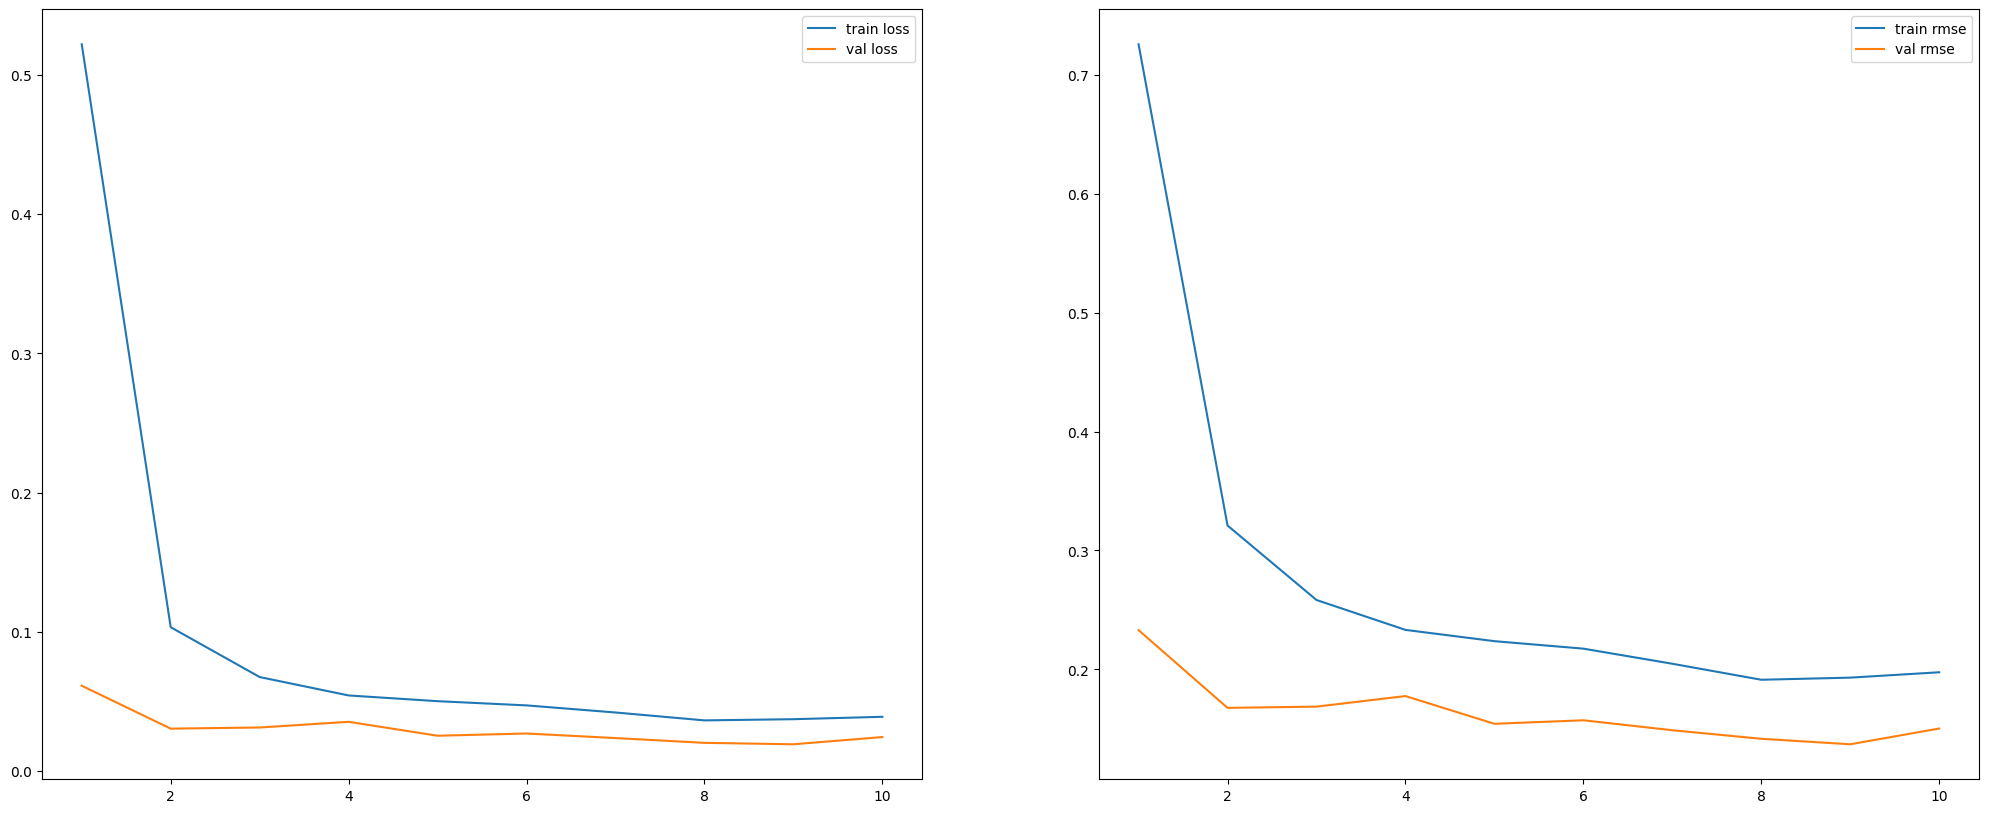

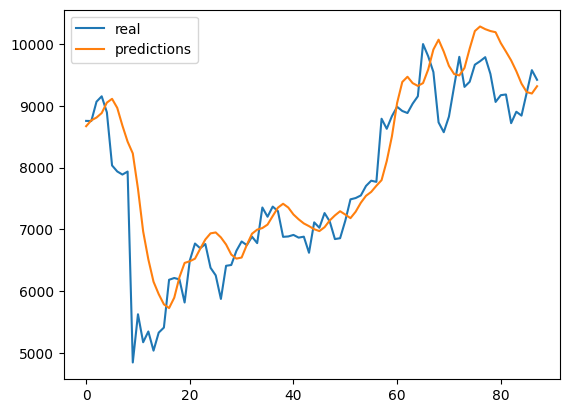

In [ ]:
btc_df = plot_results(*MultiBTC(df = df_24h, scaler = StandardScaler()))
make_model(btc_df)

Dzienny z 1h

100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


RMSE: 97.15332718910591
RMSE: 138.24427310315562


,Dates,True BTC,Predicted BTC
0,2020-03-03 23:00:00,8755.449987,8782.594016
1,2020-03-04 23:00:00,8753.279990,8770.308081
2,2020-03-05 23:00:00,9066.649997,9122.173706
3,2020-03-06 23:00:00,9153.790029,9147.559004
4,2020-03-07 23:00:00,8893.929931,8933.312523
...,...,...,...
83,2020-05-25 23:00:00,8903.560059,8921.407554
84,2020-05-26 23:00:00,8840.909956,8863.661214
85,2020-05-27 23:00:00,9209.999988,9121.302805
86,2020-05-28 23:00:00,9577.379941,9522.399230


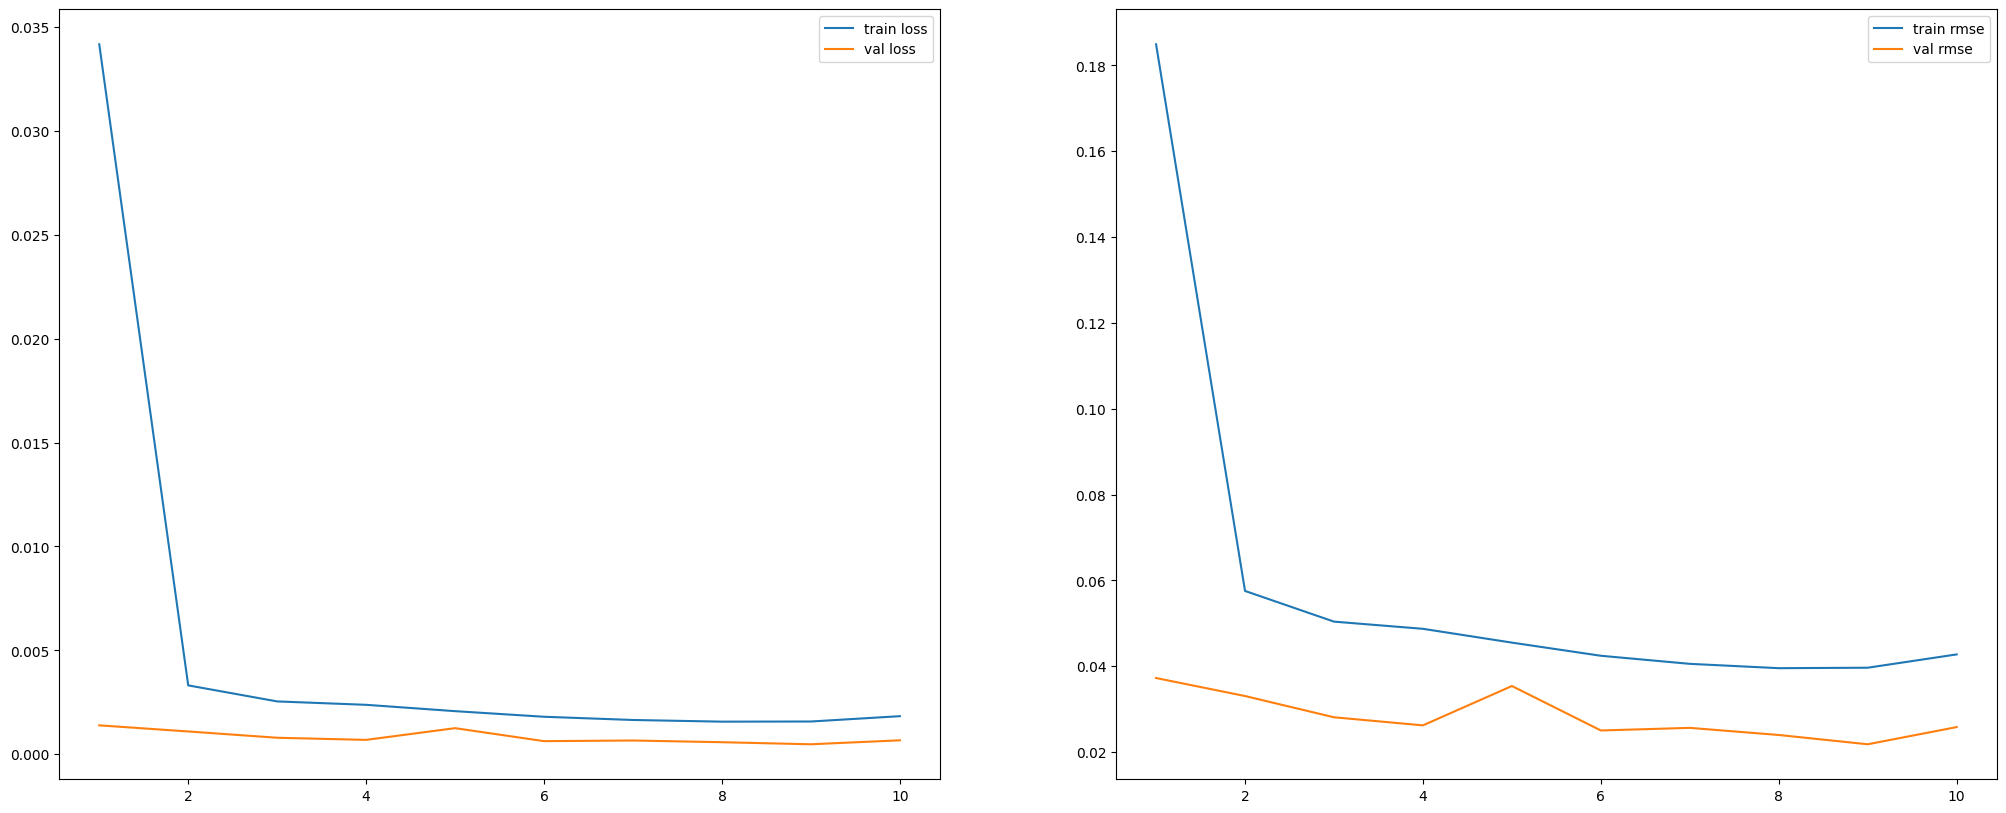

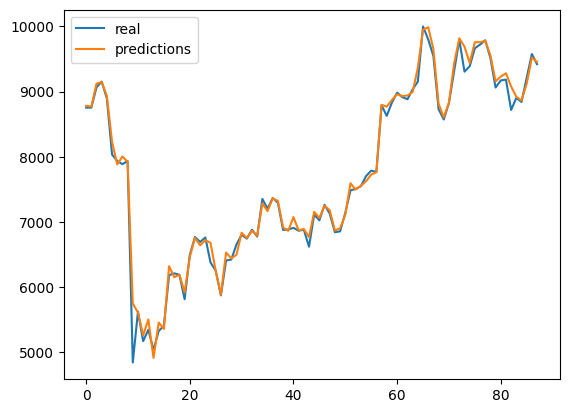

In [ ]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = StandardScaler()))
make_model(btc_df, day_model = True)

Godzinowy

100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


RMSE: 96.80048759103705
RMSE: 96.80048759103705


,Dates,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.380045,8951.765325
19008,2020-03-03 01:00:00,8828.269942,8895.587659
19009,2020-03-03 02:00:00,8879.759936,8933.035832
19010,2020-03-03 03:00:00,8880.010025,8887.788528
19011,2020-03-03 04:00:00,8842.280039,8905.559916
...,...,...,...
21114,2020-05-29 19:00:00,9403.989983,9467.543137
21115,2020-05-29 20:00:00,9421.340004,9464.329964
21116,2020-05-29 21:00:00,9394.860033,9467.295893
21117,2020-05-29 22:00:00,9427.440009,9451.672026


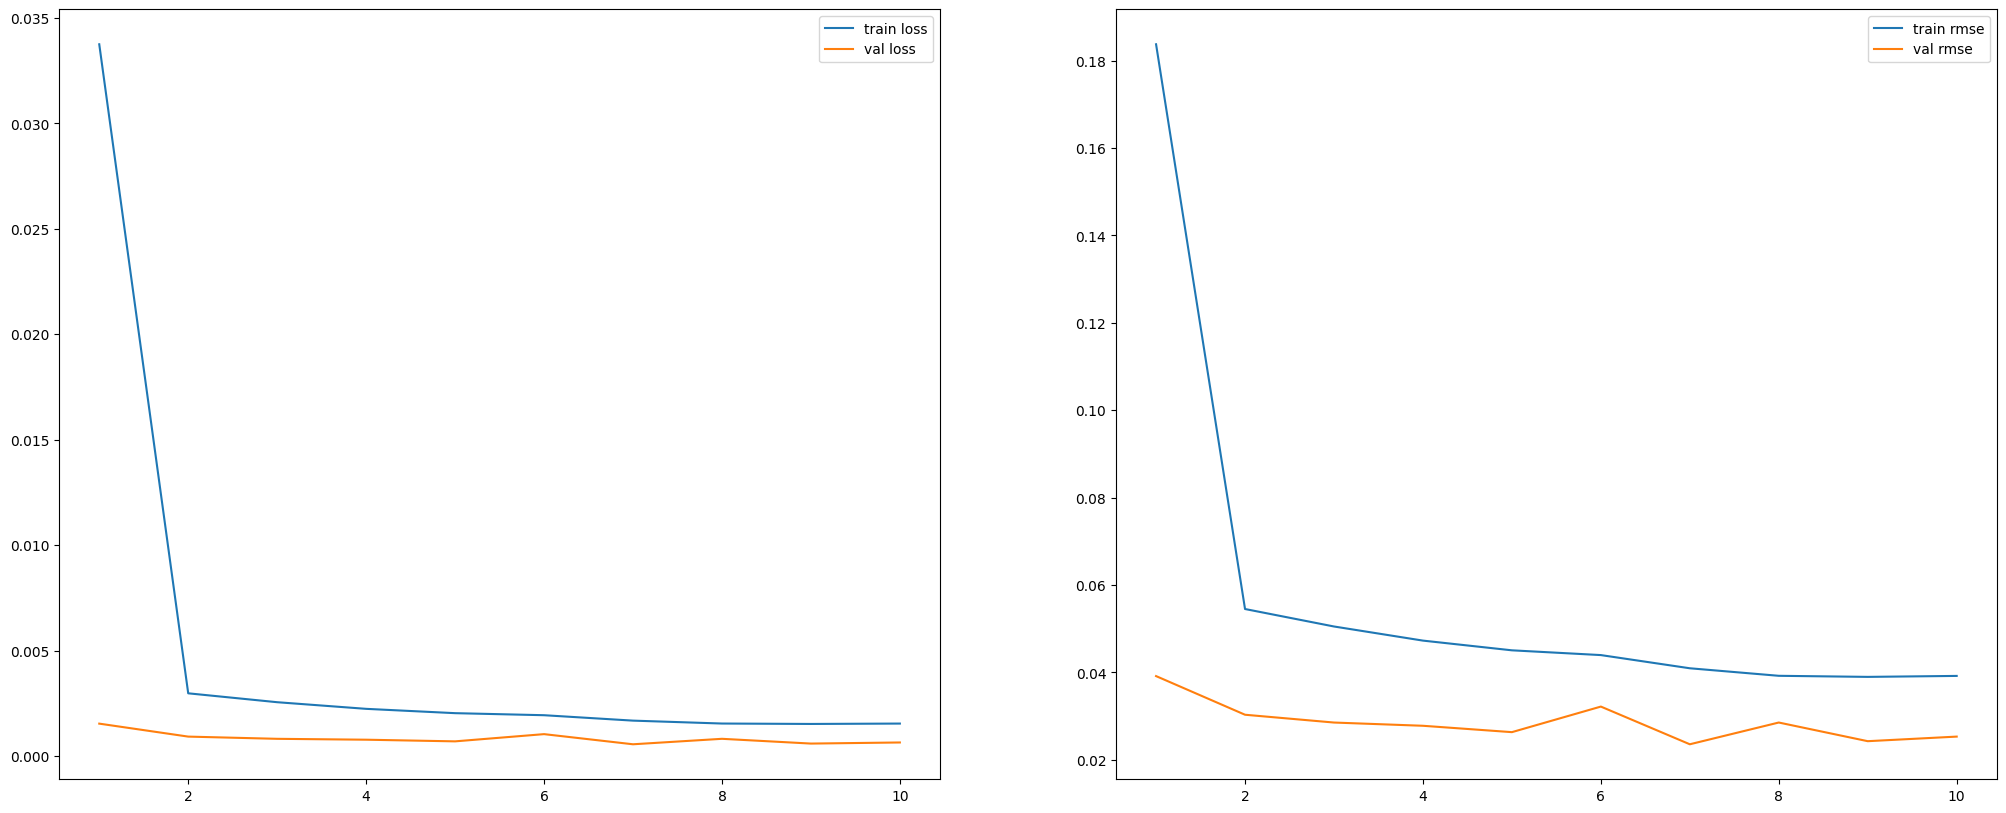

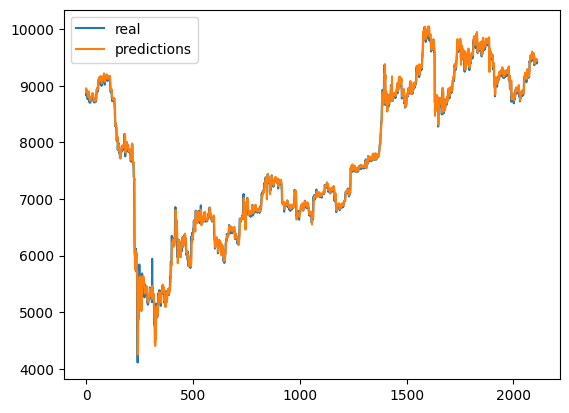

In [ ]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = StandardScaler()))
make_model(btc_df)